In [29]:
from wordcloud import WordCloud,STOPWORDS
import requests
import operator
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
from pandas import Series, DataFrame
from collections import Counter, defaultdict
from operator import itemgetter
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['prod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [30]:
review_raw = pd.read_csv('amazon_review.csv', encoding = 'utf-8')
products = pd.read_csv('amazon_product.csv',encoding='utf-8')

In [31]:
product_dict = {
    'Beats-Solo3-Wireless-Ear-Headphones': 'Beats-Solo3',
    'Sony-Cancelling-Bluetooth-Headphone-MDR1000X': 'Sony-MDR1000X',
    'beyerdynamic-770-closed-Studio-Headphone': 'Beyerdynamic-770',
    'Sennheiser-Open-Back-Professional-Headphone': 'Sennheiser-HD600',
    'Bose-QuietComfort-Acoustic-Cancelling-Headphones': 'Bose-QC25',
    'Harman-Kardon-CL-Precision-Headphones': 'Harman-Kardon-CL',
    'Samsung-Level-Over-Ear-Bluetooth-Headphone': 'Samsung-Level',
    'V-MODA-Crossfade-Over-Ear-Noise-Isolating-Headphone': 'V-MODA-M100'
}

In [32]:
review = review_raw.dropna()
review_prod = review[['review','productname']]
review_prod.loc[:,'review'] = review_prod.review.map(lambda x: x.lower())
review_prod.loc[:,'productname'] = review_prod.productname.map(lambda x: product_dict[x])

(-0.5, 399.5, 199.5, -0.5)

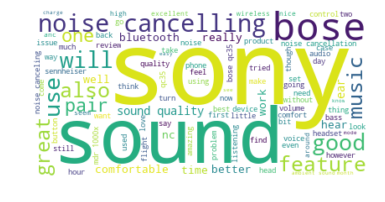

In [5]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="white",max_words=100, stopwords=stopwords)
fig, ax1 = subplots(figsize=(6, 10))

review_all = review_prod[review_prod['productname'] == 'Sony-MDR1000X']['review'].apply(lambda x: x.replace('headphone','')).sum()
wc.generate(review_all)
ax1.imshow(wc, interpolation='bilinear')
ax1.axis("off")

In [6]:
attr_replace = pd.read_csv('attr_list.csv')
attr_replace_dict = dict(zip(attr_replace.Search,attr_replace.Replace))

In [7]:
def replace_attr(review):
    for key in attr_replace_dict:
        review = review.replace(key,attr_replace_dict[key])
    return review

In [8]:
review_prod.loc[:,'review'] = review_prod.review.map(replace_attr)

In [9]:
attr = attr_replace.Replace.unique()
prod = review_prod.productname.unique()

In [10]:
review_count = {}
for p in prod:
    mask_prod = (review_prod['productname'] == p)
    review_count[p] = len(review_prod[mask_prod])

In [11]:
attr = attr_replace.Replace.unique()
attr_abs_freq = {}
attr_rel_freq = {}
for p in prod:
    prod_abs_freq = {}
    prod_rel_freq = {}
    mask_prod = (review_prod['productname'] == p)
    for a in attr:
        abs_freq = sum(review_prod[mask_prod].review.str.contains(a))
        rel_freq = abs_freq*1.0/review_count[p]
        prod_abs_freq[a] = abs_freq
        prod_rel_freq[a] = rel_freq
    attr_abs_freq[p] = prod_abs_freq
    attr_rel_freq[p] = prod_rel_freq

In [12]:
attr_rel = pd.DataFrame.from_dict({i: attr_rel_freq[i]
                           for i in attr_rel_freq.keys()},orient='index')

In [13]:
attr_tot = {}
for a in attr:
    attr_tot[a] = reduce(lambda x,y:x+y, [attr_abs_freq[p][a] for p in prod]) 
attr_tot = pd.Series(attr_tot)/len(review)

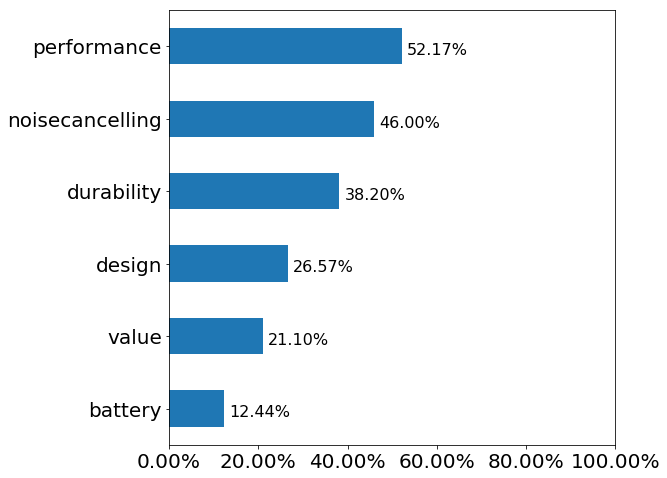

In [14]:
fig,ax = plt.subplots()
attr_tot.sort_values().plot.barh(figsize=(8, 8),xlim = (0,1),ax=ax)
for p in ax.patches:
        ax.annotate("{:3.2f}%".format(p.get_width()*100), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), size = 16, textcoords='offset points')
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.2f}%'.format(x*100) for x in vals])
ax.tick_params(labelsize=20);

In [15]:
attr_rel_sub = attr_rel.loc[['Beats-Solo3','Bose-QC25','Sony-MDR1000X']]

In [16]:
attr_rel_sub

,durability,battery,value,noisecancelling,design,performance
Beats-Solo3,0.245227,0.158115,0.134248,0.144391,0.120525,0.357399
Bose-QC25,0.365141,0.151407,0.191671,0.586873,0.225593,0.404578
Sony-MDR1000X,0.494600,0.174946,0.203024,0.708423,0.345572,0.628510


In [34]:
attr_rel.to_csv('rel_freq.csv')

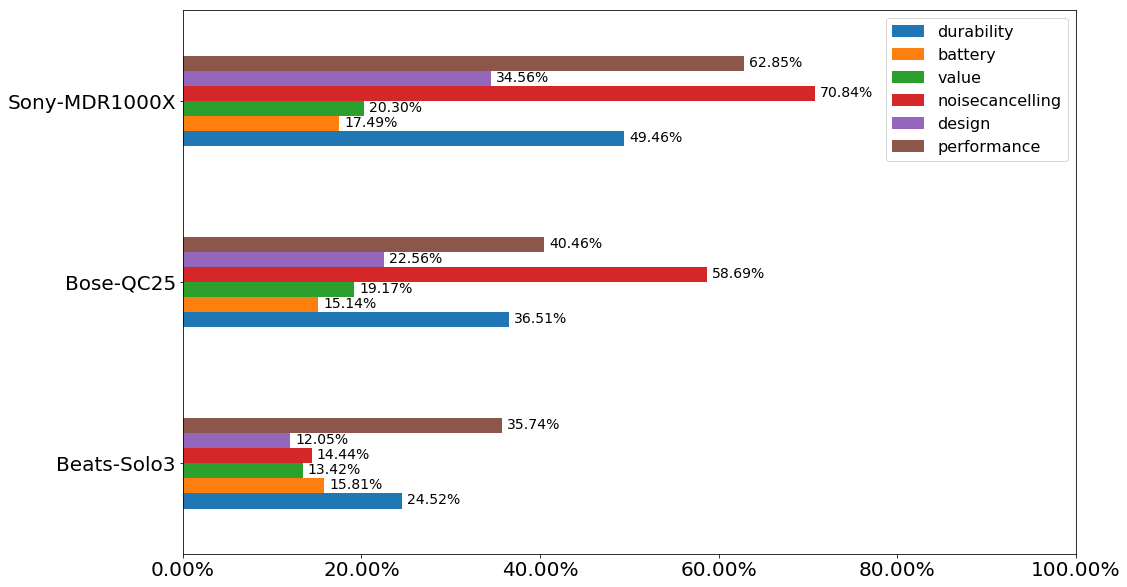

In [17]:
#only do beats bose and sennheiser

fig, ax = plt.subplots()
attr_rel_sub.plot.barh(figsize=(16, 10),xlim = (0,1), ax = ax)
for p in ax.patches:
        ax.annotate("{:3.2f}%".format(p.get_width()*100), (p.get_x() + p.get_width(), p.get_y() - 0.03), xytext=(5, 10), size = 14, textcoords='offset points')
vals = ax.get_xticks()
ax.set_xticklabels(['{:3.2f}%'.format(x*100) for x in vals]);
ax.tick_params(labelsize=20)
ax.legend(fontsize=16);
        

In [18]:
review_prod.loc[:,'sent'] = review_prod.review.apply(lambda x: sent_tokenize(x))

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
#using sentence
analyzer = SentimentIntensityAnalyzer()

brand_senti = {}
brand_score = {}

for p in prod:
    attr_senti = {}
    attr_score = {}
    mask_prod = (review_prod['productname'] == p)
    for a in attr:
        neg_score = []
        neu_score = []
        pos_score = []
        for row in review_prod[mask_prod].sent:  
            loc = [i for i, j in enumerate(row) if a in j]
            if loc != []:
                for l in loc:
                    sent = row[l]
                    score = analyzer.polarity_scores(sent)['compound'] * 1.5 #adjust vader's sentiment score 
                    if score < -0.4:
                        neg_score.append(max(score,-1))
                    elif score > 0.4:
                        pos_score.append(min(score,1))
                    else:
                        neu_score.append(score)   
            else:
                continue
        tot_score = pos_score + neu_score + neg_score
        mean_score = mean(tot_score)
        neg_tot = len(neg_score)
        neu_tot = len(neu_score)
        pos_tot = len(pos_score)
        tot = len(tot_score)
        attr_senti[a] = {'neg': neg_tot*1.0/tot, 'neu': neu_tot*1.0/tot, 'pos':pos_tot*1.0/tot}
        attr_score[a] = round(mean_score*5 + 5,2)
    brand_senti[p] = attr_senti
    brand_score[p] = attr_score

In [20]:
attr_rank_score = {}
for b in brand_score:
    for a in brand_score[b]:
        if a not in attr_rank_score:
            attr_rank_score[a] = {}
        attr_rank_score[a][b] = brand_score[b][a]

In [21]:
brand_attr_senti = pd.DataFrame.from_dict({(i,j): brand_senti[i][j]
                                           for i in brand_senti.keys()
                                           for j in brand_senti[i].keys()
                                          },orient='index')

In [22]:
brand_attr_score = pd.DataFrame.from_dict({i: brand_score[i]
                           for i in brand_score.keys()},orient='index')

In [23]:
attr_brand_score = pd.DataFrame.from_dict({i: attr_rank_score[i]
                           for i in attr_rank_score.keys()},orient='index')

In [24]:
# sorted(attr_rank_score['performance'], key=operator.itemgetter(1), reverse = True)

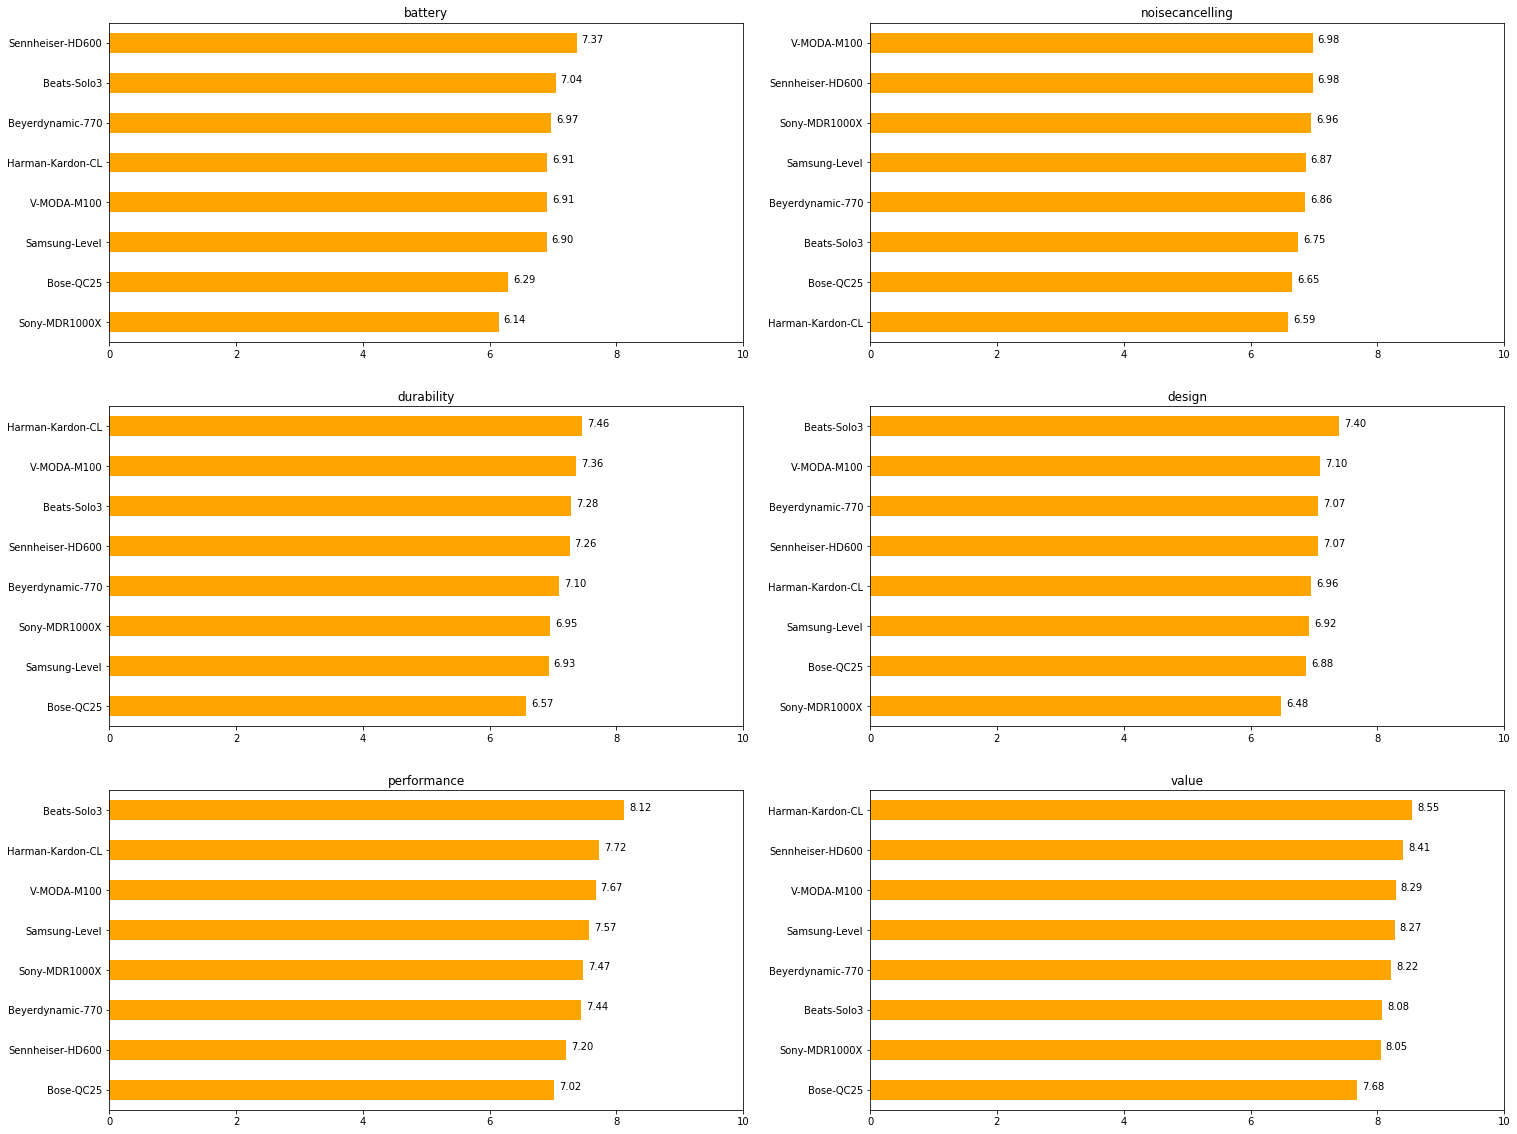

In [25]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = subplots(3,2,figsize = (25,20))
ax = [ax1,ax2,ax3,ax4,ax5,ax6]

for (a,att) in zip(ax,attr):
    attr_brand_score.loc[att].sort_values().plot.barh(ax = a, title = att, xlim = (0,10),color = 'orange')
    for p in a.patches:
        a.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

In [26]:
#attr_brand_score.loc['performance'].sort_values(ascending = False)

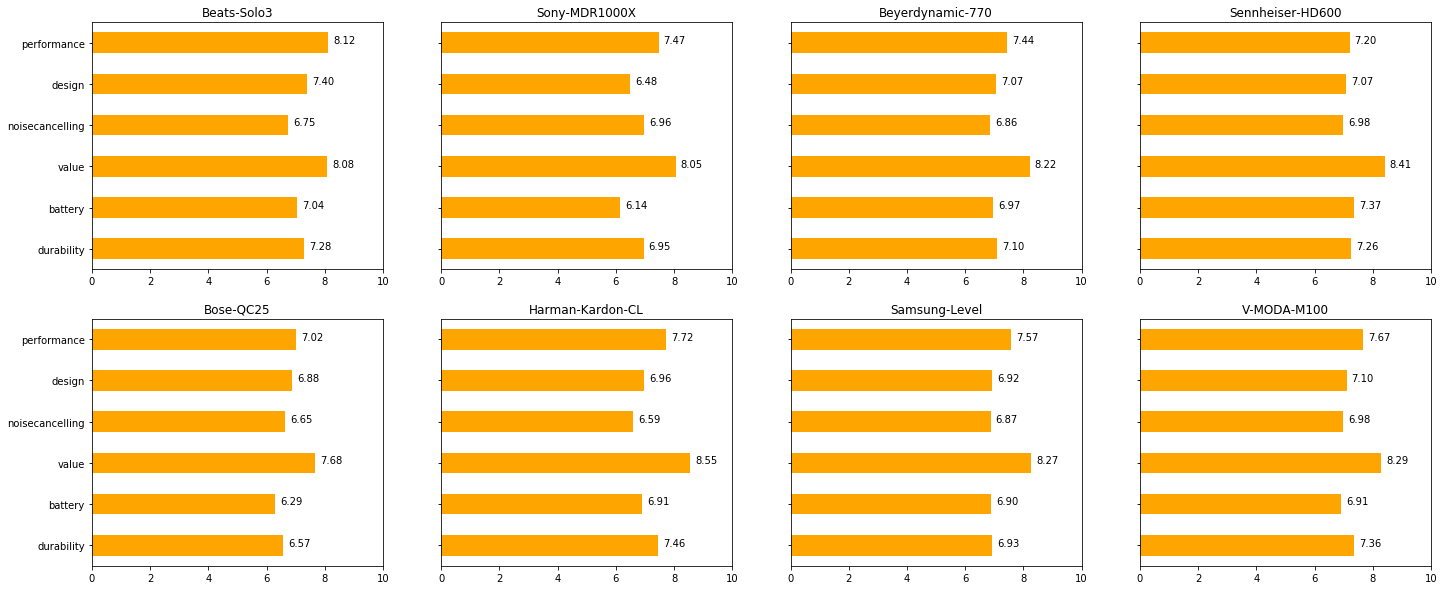

In [27]:
fig, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = subplots(2,4,figsize = (24,10),sharey = True)
ax = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for (a,p) in zip(ax,prod):
    brand_attr_score.loc[p].plot.barh(ax = a, title = p, xlim = (0,10),color = 'orange')
    for p in a.patches:
        a.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 10), textcoords='offset points')

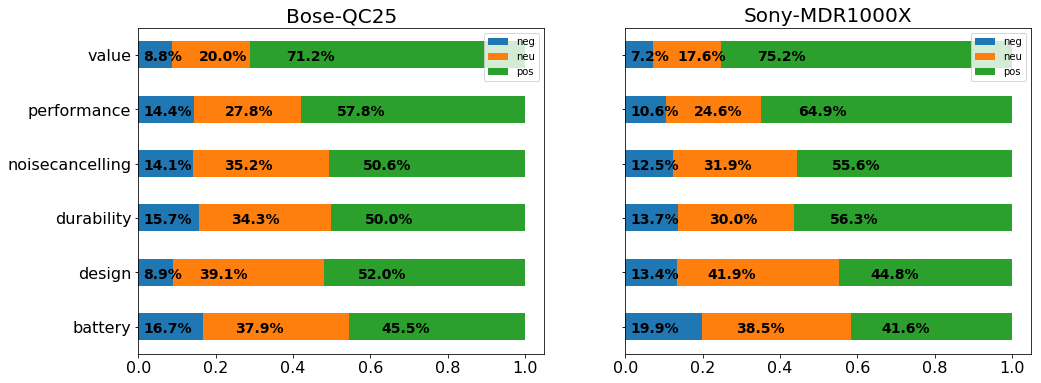

In [28]:
fig, (ax1,ax2) = subplots(1,2,figsize = (16,6),sharey = True)
ax = [ax1,ax2]


senti_comp = ['Bose-QC25','Sony-MDR1000X']
for (a,p) in zip(ax,senti_comp):
    brand_attr_senti.loc[p].plot.barh(stacked = True, ax = a)
    a.set_yticklabels = (brand_attr_senti.index.get_level_values(1))
    a.tick_params(labelsize = 16);
    a.set_title(p,fontsize = 20)
    for p in a.patches:
        a.annotate("{:3.1f}%".format(p.get_width()*100), (p.get_x()**0.8, p.get_y()+0.05), xytext=(5, 5), size = 14, weight = 'bold', textcoords='offset points')
        
        

In [35]:
brand_attr_senti.to_csv('brand_attr_senti.csv')